In [ ]:
# ============================================================================
# PART 1: INSTALLATION AND IMPORTS
# ============================================================================

# Install required packages
!pip install transformers datasets scikit-learn torch pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


Upload sentiment-analysis.csv


Saving sentiment-analysis.csv to sentiment-analysis (7).csv

=== Dataset Overview ===
(96, 7)
                                               Text  Sentiment         Source  \
0                              I love this product!   Positive        Twitter   
1                         The service was terrible.   Negative   Yelp Reviews   
2                            This movie is amazing!   Positive           IMDb   
3  I'm so disappointed with their customer support.   Negative   Online Forum   
4                Just had the best meal of my life!   Positive    TripAdvisor   

              Date/Time       User ID      Location  Confidence Score  
0   2023-06-15 09:23:14      @user123      New York              0.85  
1   2023-06-15 11:45:32       user456   Los Angeles              0.65  
2   2023-06-15 14:10:22   moviefan789        London              0.92  
3   2023-06-15 17:35:11    forumuser1       Toronto              0.78  
4   2023-06-16 08:50:59      foodie22         Paris        

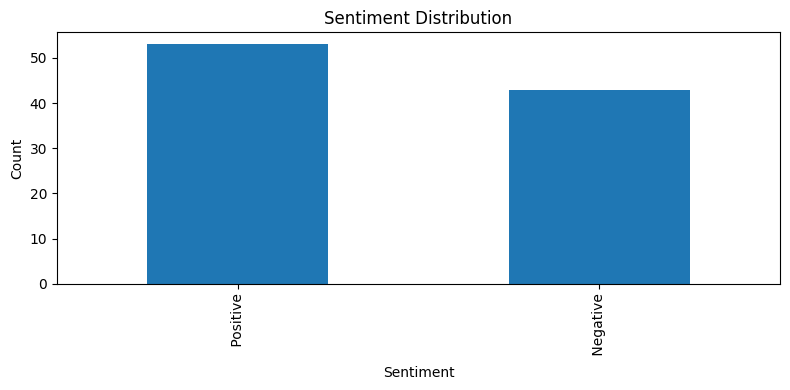

In [ ]:
# Load file
from google.colab import files
print("Upload sentiment-analysis.csv")
uploaded = files.upload()

# Get uploaded filename
filename = list(uploaded.keys())[0]

# Read CSV
df = pd.read_csv(filename, encoding='latin1')

# Clean column names if accidental spaces exist
df.columns = df.columns.str.strip()

print("\n=== Dataset Overview ===")
print(df.shape)
print(df.head())
print(df.columns)

print("\n=== Data Types ===")
print(df.dtypes)

print("\n=== Missing Values ===")
print(df.isnull().sum())

# Correct sentiment column reference
print("\n=== Sentiment Distribution ===")
print(df['Sentiment'].value_counts())

# Plot sentiment distribution
plt.figure(figsize=(8,4))
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [ ]:
# ============================================================================
# PART 3: PREPROCESSING AND TOKENIZATION
# ============================================================================

class SentimentPreprocessor:
    """Handles data preprocessing and cleaning"""

    def __init__(self, df, text_col='Text', sentiment_col='Sentiment'):
        self.df = df.copy()
        self.text_col = text_col
        self.sentiment_col = sentiment_col
        self.label_map = None

    def clean_text(self, text):
        """Basic text cleaning"""
        if pd.isna(text):
            return ""
        text = str(text).strip()
        text = ' '.join(text.split())
        return text

    def create_label_mapping(self):
        unique_labels = self.df[self.sentiment_col].unique()
        self.label_map = {label: idx for idx, label in enumerate(sorted(unique_labels))}
        self.reverse_label_map = {idx: label for label, idx in self.label_map.items()}
        return self.label_map

    def preprocess(self):
        self.df['cleaned_text'] = self.df[self.text_col].apply(self.clean_text)
        self.df = self.df[self.df['cleaned_text'].str.len() > 0].reset_index(drop=True)

        self.create_label_mapping()
        self.df['label'] = self.df[self.sentiment_col].map(self.label_map)

        print(f"\n=== Preprocessing Complete ===")
        print(f"Total samples: {len(self.df)}")
        print(f"Label mapping: {self.label_map}")

        return self.df, self.label_map, self.reverse_label_map


# Preprocess the data
preprocessor = SentimentPreprocessor(df)
processed_df, label_map, reverse_label_map = preprocessor.preprocess()

print(f"\nProcessed data sample:")
print(processed_df[['cleaned_text', 'label']].head())


=== Preprocessing Complete ===
Total samples: 96
Label mapping: {' Negative': 0, ' Positive': 1}

Processed data sample:
                                       cleaned_text  label
0                              I love this product!      1
1                         The service was terrible.      0
2                            This movie is amazing!      1
3  I'm so disappointed with their customer support.      0
4                Just had the best meal of my life!      1



=== Initializing BERT Tokenizer ===


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


Text length statistics:
Mean: 14.85
Median: 15.00
95th percentile: 21.00
Max: 24


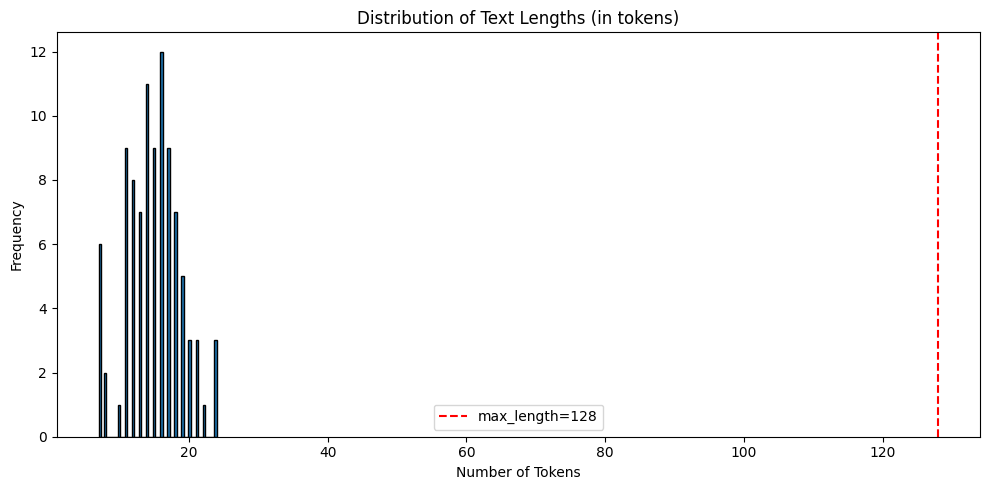

In [ ]:
# ============================================================================
# PART 4: DATASET CLASS AND TOKENIZATION
# ============================================================================

class SentimentDataset(Dataset):
    """Custom Dataset for sentiment analysis"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer
print("\n=== Initializing BERT Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Analyze text lengths for optimal max_length
text_lengths = processed_df['cleaned_text'].apply(lambda x: len(tokenizer.encode(x)))
print(f"\nText length statistics:")
print(f"Mean: {text_lengths.mean():.2f}")
print(f"Median: {text_lengths.median():.2f}")
print(f"95th percentile: {text_lengths.quantile(0.95):.2f}")
print(f"Max: {text_lengths.max()}")

# Visualize text lengths
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths (in tokens)')
plt.axvline(x=128, color='r', linestyle='--', label='max_length=128')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PART 5: TRAIN-VALIDATION SPLIT
# ============================================================================

# Split data
X = processed_df['cleaned_text'].values
y = processed_df['label'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== Data Split ===")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Training label distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Validation label distribution:\n{pd.Series(y_val).value_counts()}")

# Create datasets
train_dataset = SentimentDataset(X_train, y_train, tokenizer, max_length=128)
val_dataset = SentimentDataset(X_val, y_val, tokenizer, max_length=128)

# Create dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size: {BATCH_SIZE}")


=== Data Split ===
Training samples: 76
Validation samples: 20
Training label distribution:
1    42
0    34
Name: count, dtype: int64
Validation label distribution:
1    11
0     9
Name: count, dtype: int64

DataLoaders created with batch size: 16


In [ ]:
# ============================================================================
# PART 6: MODEL INITIALIZATION
# ============================================================================

# Initialize model
num_labels = len(label_map)
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)
model = model.to(device)

print(f"\n=== Model Initialized ===")
print(f"Number of labels: {num_labels}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Model Initialized ===
Number of labels: 2
Model parameters: 109,483,778


In [ ]:
# ============================================================================
# PART 7: TRAINING CONFIGURATION
# ============================================================================

# Training hyperparameters
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 0
MAX_GRAD_NORM = 1.0

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f"\n=== Training Configuration ===")
print(f"Epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Total training steps: {total_steps}")


=== Training Configuration ===
Epochs: 3
Learning rate: 2e-05
Total training steps: 15


In [ ]:
# ============================================================================
# PART 8: TRAINING PIPELINE
# ============================================================================

def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions, true_labels = [], []

    progress_bar = tqdm(dataloader, desc="Training")

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
        optimizer.step()
        scheduler.step()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1

def evaluate(model, dataloader, device):
    """Evaluate the model"""
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')

    return avg_loss, accuracy, f1, predictions, true_labels

# Training loop
print("\n=== Starting Training ===")
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': []
}

best_val_f1 = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    print("-" * 50)

    # Train
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )

    # Validate
    val_loss, val_acc, val_f1, val_preds, val_true = evaluate(
        model, val_loader, device
    )

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_sentiment_model.pt')
        print(f"✓ Saved best model (F1: {best_val_f1:.4f})")

print("\n=== Training Complete ===")


=== Starting Training ===

Epoch 1/3
--------------------------------------------------


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.72s/it]



Train Loss: 0.6617 | Train Acc: 0.5789 | Train F1: 0.5317
Val Loss: 0.5435 | Val Acc: 0.9000 | Val F1: 0.8979
✓ Saved best model (F1: 0.8979)

Epoch 2/3
--------------------------------------------------


Evaluating: 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]



Train Loss: 0.5380 | Train Acc: 0.8421 | Train F1: 0.8397
Val Loss: 0.4731 | Val Acc: 1.0000 | Val F1: 1.0000
✓ Saved best model (F1: 1.0000)

Epoch 3/3
--------------------------------------------------


Evaluating: 100%|██████████| 2/2 [00:07<00:00,  3.77s/it]


Train Loss: 0.4911 | Train Acc: 0.9342 | Train F1: 0.9338
Val Loss: 0.4264 | Val Acc: 1.0000 | Val F1: 1.0000

=== Training Complete ===



=== Final Evaluation ===


Evaluating: 100%|██████████| 2/2 [00:08<00:00,  4.09s/it]



=== Final Metrics ===
Accuracy: 1.0000
F1-Score (weighted): 1.0000

=== Classification Report ===
              precision    recall  f1-score   support

    Negative     1.0000    1.0000    1.0000         9
    Positive     1.0000    1.0000    1.0000        11

    accuracy                         1.0000        20
   macro avg     1.0000    1.0000    1.0000        20
weighted avg     1.0000    1.0000    1.0000        20



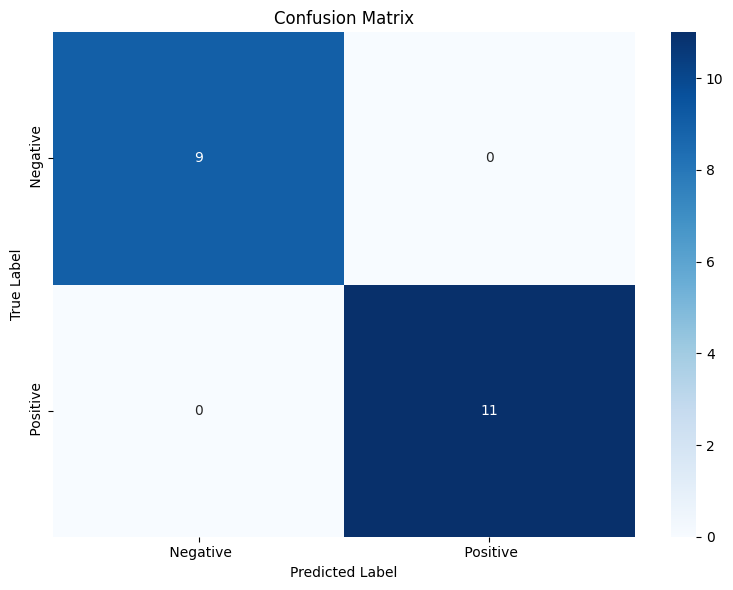


=== Per-Class Metrics ===
 Negative: Accuracy = 1.0000
 Positive: Accuracy = 1.0000


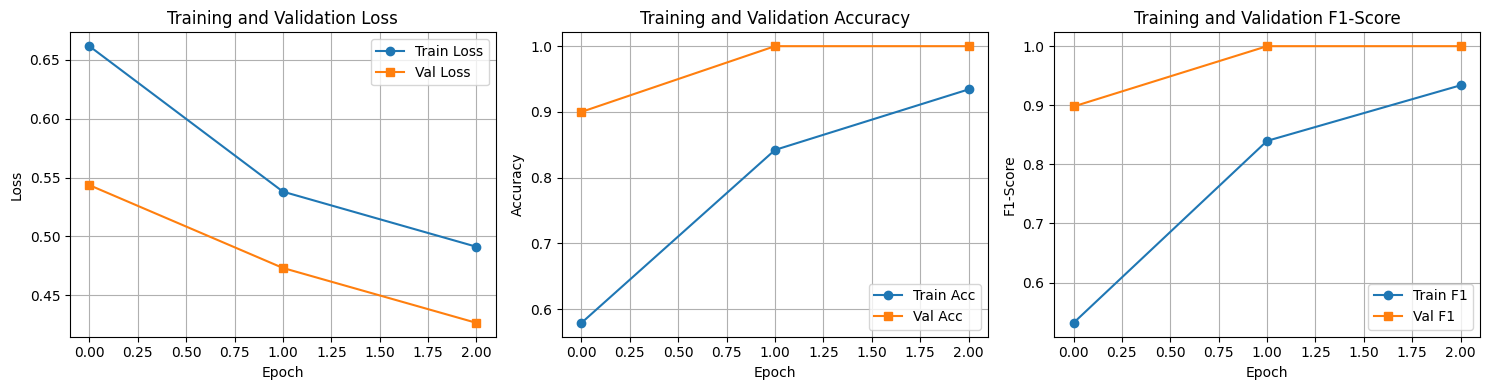

In [ ]:
# ============================================================================
# PART 9: EVALUATION METRICS
# ============================================================================

# Load best model
model.load_state_dict(torch.load('best_sentiment_model.pt'))
print("\n=== Final Evaluation ===")

# Get final predictions
_, val_acc, val_f1, final_preds, final_true = evaluate(model, val_loader, device)

print(f"\n=== Final Metrics ===")
print(f"Accuracy: {val_acc:.4f}")
print(f"F1-Score (weighted): {val_f1:.4f}")

# Detailed classification report
print("\n=== Classification Report ===")
print(classification_report(
    final_true,
    final_preds,
    target_names=[reverse_label_map[i] for i in sorted(reverse_label_map.keys())],
    digits=4
))

# Confusion Matrix
cm = confusion_matrix(final_true, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[reverse_label_map[i] for i in sorted(reverse_label_map.keys())],
    yticklabels=[reverse_label_map[i] for i in sorted(reverse_label_map.keys())]
)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class metrics
print("\n=== Per-Class Metrics ===")
for i in sorted(reverse_label_map.keys()):
    class_name = reverse_label_map[i]
    class_mask = np.array(final_true) == i
    class_acc = accuracy_score(
        np.array(final_true)[class_mask],
        np.array(final_preds)[class_mask]
    )
    print(f"{class_name}: Accuracy = {class_acc:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

# F1-Score
axes[2].plot(history['train_f1'], label='Train F1', marker='o')
axes[2].plot(history['val_f1'], label='Val F1', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1-Score')
axes[2].set_title('Training and Validation F1-Score')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# PART 10: EXAMPLE PREDICTIONS
# ============================================================================

def predict_sentiment(text, model, tokenizer, label_map, device, max_length=128):
    """Predict sentiment for a single text"""
    model.eval()

    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probs, dim=1).item()
        confidence = probs[0][prediction].item()

    return reverse_label_map[prediction], confidence, probs[0].cpu().numpy()

# Example predictions
print("\n=== Example Predictions ===")

example_texts = [
    "I love this product! It's amazing and works perfectly.",
    "Terrible experience. Would not recommend to anyone.",
    "It's okay, nothing special but not bad either.",
    "Absolutely fantastic! Best purchase I've made.",
    "Very disappointing. Waste of money."
]

results = []
for text in example_texts:
    sentiment, confidence, probs = predict_sentiment(
        text, model, tokenizer, label_map, device
    )
    results.append({
        'Text': text,
        'Predicted Sentiment': sentiment,
        'Confidence': f"{confidence:.4f}"
    })

    print(f"\nText: {text}")
    print(f"Predicted: {sentiment} (Confidence: {confidence:.4f})")
    print(f"Probabilities: {dict(zip([reverse_label_map[i] for i in sorted(reverse_label_map.keys())], [f'{p:.4f}' for p in probs]))}")

# Convert to DataFrame for better display
results_df = pd.DataFrame(results)
print("\n=== Summary of Example Predictions ===")
print(results_df.to_string(index=False))



=== Example Predictions ===

Text: I love this product! It's amazing and works perfectly.
Predicted:  Positive (Confidence: 0.6593)
Probabilities: {' Negative': '0.3407', ' Positive': '0.6593'}

Text: Terrible experience. Would not recommend to anyone.
Predicted:  Positive (Confidence: 0.5152)
Probabilities: {' Negative': '0.4848', ' Positive': '0.5152'}

Text: It's okay, nothing special but not bad either.
Predicted:  Negative (Confidence: 0.5109)
Probabilities: {' Negative': '0.5109', ' Positive': '0.4891'}

Text: Absolutely fantastic! Best purchase I've made.
Predicted:  Positive (Confidence: 0.6804)
Probabilities: {' Negative': '0.3196', ' Positive': '0.6804'}

Text: Very disappointing. Waste of money.
Predicted:  Negative (Confidence: 0.5037)
Probabilities: {' Negative': '0.5037', ' Positive': '0.4963'}

=== Summary of Example Predictions ===
                                                  Text Predicted Sentiment Confidence
I love this product! It's amazing and works perfectly

In [ ]:
# ============================================================================
# PART 11: SAVE MODEL AND ARTIFACTS
# ============================================================================

# Save final model and tokenizer
model.save_pretrained('./sentiment_model')
tokenizer.save_pretrained('./sentiment_model')

# Save label mappings
import json
with open('label_mapping.json', 'w') as f:
    json.dump({
        'label_map': label_map,
        'reverse_label_map': reverse_label_map
    }, f, indent=2)

print("\n=== Model and Artifacts Saved ===")
print("Model saved to: ./sentiment_model")
print("Label mapping saved to: label_mapping.json")
print("Best model weights saved to: best_sentiment_model.pt")

# Download files
from google.colab import files
print("\n=== Download Files ===")
files.download('best_sentiment_model.pt')
files.download('label_mapping.json')

print("\n✓ All tasks completed successfully!")
print("\nDeliverables:")
print("1. ✓ Preprocessing and tokenization script")
print("2. ✓ Training and validation pipeline")
print("3. ✓ Evaluation metrics (accuracy, F1-score, confusion matrix)")
print("4. ✓ Example predictions")


=== Model and Artifacts Saved ===
Model saved to: ./sentiment_model
Label mapping saved to: label_mapping.json
Best model weights saved to: best_sentiment_model.pt

=== Download Files ===


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ All tasks completed successfully!

Deliverables:
1. ✓ Preprocessing and tokenization script
2. ✓ Training and validation pipeline
3. ✓ Evaluation metrics (accuracy, F1-score, confusion matrix)
4. ✓ Example predictions
